In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load noise

In [2]:
LoadDA = pd.read_csv("./Processed Data/2022/Load_C.csv")[['1','2','3','4','5','6','7']]
load_column_names = ['region1_load', 'region2_load', 'region3_load','region4_load', 'region5_load', 'region6_load', 'region7_load']
LoadDA.columns = load_column_names
new_index = np.arange(LoadDA.index.min(), LoadDA.index.max() + 1, 1/12)
LoadDA_reindexed = LoadDA.reindex(new_index).reset_index(drop=True)
LoadDA_interpolated = LoadDA_reindexed.interpolate(method='linear')

In [3]:
LoadRT = pd.read_csv("./Processed Data/2022/realtimeload_C_fixed.csv",header=None,usecols=[1, 2, 3])
load_column_names_rt = ['region1_load', 'region2_load', 'region3_load']
LoadRT.columns = load_column_names_rt

In [4]:
# Create the new DataFrame
load_train_list = []
    
for i in range(0,3):
    # Calculate max of LoadDA
    mean_LoadDA = LoadDA.mean()[i]

    for j in range(288, len(LoadRT)):
        da_window = LoadDA.iloc[int(j/12)-24:int(j/12),i].values
        rt_window = LoadRT.iloc[j-12:j,i].values
        current_load = LoadRT.iloc[j,i]
        new_row = np.concatenate((da_window, rt_window, [mean_LoadDA], [current_load]))
        load_train_list.append(new_row)

load_train = pd.DataFrame(load_train_list, columns=[f'DA{j+1}' for j in range(24)] + [f'RT{j+1}' for j in range(12)] + ['Mean', 'y'])

C:\Users\wenmi\AppData\Local\Temp\ipykernel_7204\529271918.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_LoadDA = LoadDA.mean()[i]


In [5]:
# Selecting features and target variables
X_load = load_train.iloc[:,0:37]
y_load = load_train.iloc[:,37]

# Splitting the data
X_load_train, X_load_test, y_load_train, y_load_test = train_test_split(X_load, y_load, test_size=0.2, random_state=42)

# Training the model
load_model = LinearRegression()
load_model.fit(X_load_train, y_load_train)

# Predicting
load_predictions = load_model.predict(X_load_test)

# Evaluation
load_mae = mean_absolute_error(y_load_test, load_predictions)
print(f"Mean Absolute Error: {load_mae}")

Mean Absolute Error: 73.05190130103773


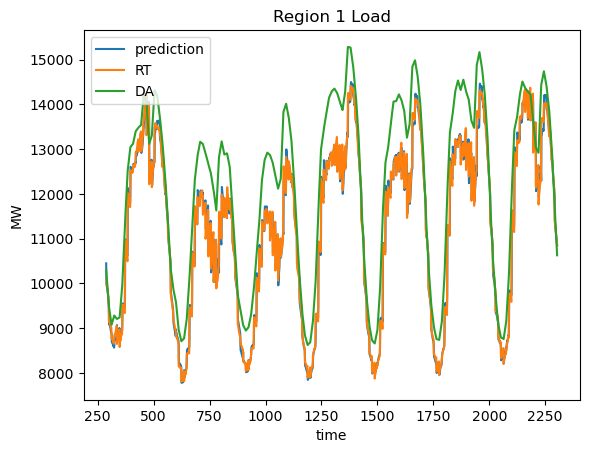

In [6]:
test_load_predictions = load_model.predict(X_load)

a = 288
b = 2304

x = np.arange(a, b, 1)  # Common x-axis values for both lines
ya = test_load_predictions[a-288:b-288]  # First set of y-axis values
yb = LoadRT['region1_load'][a:b]  # Second set of y-axis values
yc = LoadDA_interpolated['region1_load'][a:b]  # Second set of y-axis values


# Create the plot
plt.plot(x, ya, label='prediction')  # Plot the first line
plt.plot(x, yb, label='RT')  # Plot the second line
plt.plot(x, yc, label='DA')  # Plot the thrid line


# Adding labels and title
plt.xlabel('time')  # Replace with your X-axis label
plt.ylabel('MW')  # Replace with your Y-axis label
plt.title('Region 1 Load')  # Replace with your plot title

# Adding a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
load_predictions_df = pd.DataFrame(np.nan, index=range(105408), columns=range(7))

for i in range(3,7):
    # Calculate max of LoadDA
    mean_LoadDA = LoadDA.mean()[i]
    rt_window = LoadDA_interpolated.iloc[276:288,i].values

    for j in range(288, len(LoadRT)):
        da_window = LoadDA.iloc[int(j/12)-24:int(j/12),i].values
        new_test = np.concatenate((da_window, rt_window, [mean_LoadDA])).reshape(1, -1)
        prediction = load_model.predict(new_test)
        load_predictions_df.iloc[j, i] = prediction
        rt_window = np.concatenate((rt_window[1:12],prediction))

C:\Users\wenmi\AppData\Local\Temp\ipykernel_7204\1208166971.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_LoadDA = LoadDA.mean()[i]
C:\Users\wenmi\.conda\envs\STESTS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\wenmi\.conda\envs\STESTS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\wenmi\.conda\envs\STESTS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\wenmi\.conda\envs\STESTS\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
load_predictions_df

In [ ]:
load_predictions_df.columns = load_column_names
load_predictions_df[['region1_load','region2_load','region3_load']] = LoadRT[['region1_load','region2_load','region3_load']]
load_predictions_df.loc[0:288, ['region4_load','region5_load','region6_load','region7_load']] = LoadDA_interpolated.loc[0:288, ['region4_load','region5_load','region6_load','region7_load']]

In [ ]:
a = 0
b = 2304

x = np.arange(a, b, 1)  # Common x-axis values for both lines
ya = load_predictions_df['region4_load'][a:b]  # First set of y-axis values
yb = LoadDA_interpolated['region4_load'][a:b]  # Second set of y-axis values

# Create the plot
plt.plot(x, ya, label='RT_prediction')  # Plot the first line
plt.plot(x, yb, label='DA')  # Plot the second line

# Adding labels and title
plt.xlabel('time')  # Replace with your X-axis label
plt.ylabel('Normalized')  # Replace with your Y-axis label
plt.title('Region 4 Load')  # Replace with your plot title

# Adding a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
load_predictions_df

In [14]:
load_predictions_df.to_csv('Processed Data/2022/realtimeload_all.csv', header=False, index=False)

In [ ]:
repeated_index = np.repeat(LoadDA.index, 12)
repeated_loadDA = LoadDA.loc[repeated_index].reset_index(drop=True)
LoadMAE = mean_absolute_error(repeated_loadDA, load_predictions_df)
LoadMAPE = mean_absolute_percentage_error(load_predictions_df, repeated_loadDA)
AdjustedEDL = pd.read_csv("./AdjustedEDL.csv")
AdjustedEDL.columns = load_column_names
AdjustedLoadMAE = mean_absolute_error(repeated_loadDA, AdjustedEDL)
AdjustedLoadMAPE = mean_absolute_percentage_error(AdjustedEDL, repeated_loadDA)
print("Load MAE %s MAPE %s; Adjusted load MAE %s MAPE %s" % (LoadMAE, LoadMAPE, AdjustedLoadMAE, AdjustedLoadMAPE))


### Solar noise

In [ ]:
SolarDA = pd.read_csv("./Processed Data/SolarZone_C.csv")[['0','1','2','3','4','5','6']]
solar_column_names = ['region1_solar', 'region2_solar', 'region3_solar','region4_solar', 'region5_solar', 'region6_solar', 'region7_solar']
SolarDA.columns = solar_column_names
new_index = np.arange(SolarDA.index.min(), SolarDA.index.max() + 1, 1/12)
SolarDA_reindexed = SolarDA.reindex(new_index).reset_index(drop=True)
SolarDA_interpolated = SolarDA_reindexed.interpolate(method='linear')

In [ ]:
SolarRT = pd.read_csv("./Processed Data/realtimesolar123.csv",header=None,usecols=[0, 1, 2])
solar_column_names_rt = ['region1_solar', 'region2_solar', 'region3_solar']
SolarRT.columns = solar_column_names_rt

In [ ]:
# Create the new DataFrame
solar_train_list = []
    
for i in range(0,3):
    # Calculate max of LoadDA
    mean_SolarDA = SolarDA.mean()[i]

    for j in range(288, len(SolarRT)):
        da_window = SolarDA.iloc[int(j/12)-24:int(j/12),i].values
        rt_window = SolarRT.iloc[j-12:j,i].values
        current_solar = SolarRT.iloc[j,i]
        new_row = np.concatenate((da_window, rt_window, [mean_SolarDA], [current_solar]))
        solar_train_list.append(new_row)

solar_train = pd.DataFrame(solar_train_list, columns=[f'DA{j+1}' for j in range(24)] + [f'RT{j+1}' for j in range(12)] + ['Mean', 'y'])

In [ ]:
# Selecting features and target variables
X_solar = solar_train.iloc[:,0:37]
y_solar = solar_train.iloc[:,37]

# Splitting the data
X_solar_train, X_solar_test, y_solar_train, y_solar_test = train_test_split(X_solar, y_solar, test_size=0.2, random_state=42)

# Training the model
solar_model = LinearRegression()
solar_model.fit(X_solar_train, y_solar_train)

# Predicting
solar_predictions = solar_model.predict(X_solar_test)

# Evaluation
solar_mae = mean_absolute_error(y_solar_test, solar_predictions)
print(f"Mean Absolute Error: {solar_mae}")

In [ ]:
test_solar_predictions = solar_model.predict(X_solar)

a = 288
b = 2304

x = np.arange(a, b, 1)  # Common x-axis values for both lines
ya = test_solar_predictions[a-288:b-288]  # First set of y-axis values
yb = SolarRT['region1_solar'][a:b]  # Second set of y-axis values
yc = SolarDA_interpolated['region1_solar'][a:b]  # Second set of y-axis values


# Create the plot
plt.plot(x, ya, label='prediction')  # Plot the first line
plt.plot(x, yb, label='RT')  # Plot the second line
plt.plot(x, yc, label='DA')  # Plot the thrid line


# Adding labels and title
plt.xlabel('time')  # Replace with your X-axis label
plt.ylabel('MW')  # Replace with your Y-axis label
plt.title('Region 1 Solar')  # Replace with your plot title

# Adding a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
solar_predictions_df = pd.DataFrame(np.nan, index=range(105408), columns=range(7))

for i in range(3,7):
    # Calculate max of SolarDA
    mean_SolarDA = SolarDA.mean()[i]
    rt_window = SolarDA_interpolated.iloc[276:288,i].values

    for j in range(288, len(SolarRT)):
        da_window = SolarDA.iloc[int(j/12)-24:int(j/12),i].values
        new_test = np.concatenate((da_window, rt_window, [mean_SolarDA])).reshape(1, -1)
        prediction = solar_model.predict(new_test)
        solar_predictions_df.iloc[j, i] = prediction
        rt_window = np.concatenate((rt_window[1:12],prediction))

In [ ]:
solar_predictions_df.columns = solar_column_names
solar_predictions_df[['region1_solar','region2_solar','region3_solar']] = SolarRT[['region1_solar','region2_solar','region3_solar']]
solar_predictions_df.loc[0:288, ['region4_solar','region5_solar','region6_solar','region7_solar']] = SolarDA_interpolated.loc[0:288, ['region4_solar','region5_solar','region6_solar','region7_solar']]

In [ ]:
solar_predictions_df[(solar_predictions_df < 0) | (SolarDA_interpolated<=1)] = 0

In [ ]:
a = 0
b = 2304

x = np.arange(a, b, 1)  # Common x-axis values for both lines
ya = solar_predictions_df['region5_solar'][a:b]  # First set of y-axis values
yb = SolarDA_interpolated['region5_solar'][a:b]  # Second set of y-axis values

# Create the plot
plt.plot(x, ya, label='RT_prediction')  # Plot the first line
plt.plot(x, yb, label='DA')  # Plot the second line

# Adding labels and title
plt.xlabel('time')  # Replace with your X-axis label
plt.ylabel('MW')  # Replace with your Y-axis label
plt.title('Region 4 Solar')  # Replace with your plot title

# Adding a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
solar_predictions_df.to_csv('Processed Data/realtimesolar_all.csv', header=False, index=False)

In [ ]:
repeated_index = np.repeat(SolarDA.index, 12)
repeated_solarDA = SolarDA.loc[repeated_index].reset_index(drop=True)
SolarMAE = mean_absolute_error(repeated_solarDA, solar_predictions_df)
SolarMAPE = ((repeated_solarDA - solar_predictions_df).abs() / solar_predictions_df.max()).mean().mean()
AdjustedSolar = pd.read_csv("./AdjustedEDSolar.csv")
AdjustedSolar.columns = solar_column_names
AdjustedSolarMAE = mean_absolute_error(repeated_solarDA, AdjustedSolar)
AdjustedSolarMAPE = ((repeated_solarDA - AdjustedSolar).abs() / AdjustedSolar.max()).mean().mean()
print("Solar MAE %s MAPE %s; Adjusted solar MAE %s MAPE %s" % (SolarMAE, SolarMAPE, AdjustedSolarMAE, AdjustedSolarMAPE))

### Wind noise

In [ ]:
WindDA = pd.read_csv("./Processed Data/WindZone_C.csv")[['0','1','2','3','4','5','6']]
wind_column_names = ['region1_wind', 'region2_wind', 'region3_wind','region4_wind', 'region5_wind', 'region6_wind', 'region7_wind']
WindDA.columns = wind_column_names
new_index = np.arange(WindDA.index.min(), WindDA.index.max() + 1, 1/12)
WindDA_reindexed = WindDA.reindex(new_index).reset_index(drop=True)
WindDA_interpolated = WindDA_reindexed.interpolate(method='linear')

In [ ]:
WindRT = pd.read_csv("./Processed Data/realtimewind123.csv",header=None,usecols=[0, 1, 2])
wind_column_names_rt = ['region1_wind', 'region2_wind', 'region3_wind']
WindRT.columns = wind_column_names_rt

In [ ]:
# Create the new DataFrame
wind_train_list = []
    
for i in range(0,3):
    # Calculate mean of WindDA
    mean_WindDA = WindDA.mean()[i]

    for j in range(288, len(WindRT)):
        da_window = WindDA.iloc[int(j/12)-24:int(j/12),i].values
        rt_window = WindRT.iloc[j-12:j,i].values
        current_wind = WindRT.iloc[j,i]
        new_row = np.concatenate((da_window, rt_window, [mean_WindDA], [current_wind]))
        wind_train_list.append(new_row)

wind_train = pd.DataFrame(wind_train_list, columns=[f'DA{j+1}' for j in range(24)] + [f'RT{j+1}' for j in range(12)] + ['Mean', 'y'])

In [ ]:
# Selecting features and target variables
X_wind = wind_train.iloc[:,0:37]
y_wind = wind_train.iloc[:,37]

# Splitting the data
X_wind_train, X_wind_test, y_wind_train, y_wind_test = train_test_split(X_wind, y_wind, test_size=0.2, random_state=42)

# Training the model
wind_model = LinearRegression()
wind_model.fit(X_wind_train, y_wind_train)

# Predicting
wind_predictions = wind_model.predict(X_wind_test)

# Evaluation
wind_mae = mean_absolute_error(y_wind_test, wind_predictions)
print(f"Mean Absolute Error: {wind_mae}")

In [ ]:
test_wind_predictions = wind_model.predict(X_wind)

a = 288
b = 2304

x = np.arange(a, b, 1)  # Common x-axis values for both lines
ya = test_wind_predictions[a-288:b-288]  # First set of y-axis values
yb = WindRT['region1_wind'][a:b]  # Second set of y-axis values
yc = WindDA_interpolated['region1_wind'][a:b]  # Second set of y-axis values


# Create the plot
# plt.plot(x, ya, label='prediction')  # Plot the first line
plt.plot(x, yb, label='RT')  # Plot the second line
plt.plot(x, yc, label='DA')  # Plot the thrid line


# Adding labels and title
plt.xlabel('time')  # Replace with your X-axis label
plt.ylabel('MW')  # Replace with your Y-axis label
plt.title('Region 1 Wind')  # Replace with your plot title

# Adding a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
wind_predictions_df = pd.DataFrame(np.nan, index=range(105408), columns=range(7))

for i in range(3,7):
    # Calculate mean of WindDA
    mean_WindDA = WindDA.mean()[i]
    rt_window = WindDA_interpolated.iloc[276:288,i].values

    for j in range(288, len(WindRT)):
        da_window = WindDA.iloc[int(j/12)-24:int(j/12),i].values
        new_test = np.concatenate((da_window, rt_window, [mean_WindDA])).reshape(1, -1)
        prediction = wind_model.predict(new_test)
        wind_predictions_df.iloc[j, i] = prediction
        rt_window = np.concatenate((rt_window[1:12],prediction))

In [ ]:
wind_predictions_df.columns = wind_column_names
wind_predictions_df[['region1_wind','region2_wind','region3_wind']] = WindRT[['region1_wind','region2_wind','region3_wind']]
wind_predictions_df.loc[0:288, ['region4_wind','region5_wind','region6_wind','region7_wind']] = WindDA_interpolated.loc[0:288, ['region4_wind','region5_wind','region6_wind','region7_wind']]

In [ ]:
a = 0
b = 2304

x = np.arange(a, b, 1)  # Common x-axis values for both lines
ya = wind_predictions_df['region4_wind'][a:b]  # First set of y-axis values
yb = WindDA_interpolated['region4_wind'][a:b]  # Second set of y-axis values

# Create the plot
plt.plot(x, ya, label='RT_prediction')  # Plot the first line
plt.plot(x, yb, label='DA')  # Plot the second line

# Adding labels and title
plt.xlabel('time')  # Replace with your X-axis label
plt.ylabel('MW')  # Replace with your Y-axis label
plt.title('Region 4 Wind')  # Replace with your plot title

# Adding a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
wind_predictions_df.to_csv('Processed Data/realtimewind_all.csv', header=False, index=False)

In [ ]:
repeated_index = np.repeat(WindDA.index, 12)
repeated_windDA = WindDA.loc[repeated_index].reset_index(drop=True)
WindMAE = mean_absolute_error(repeated_windDA, wind_predictions_df)
WindMAPE = ((repeated_windDA - wind_predictions_df).abs() / wind_predictions_df.max()).mean().mean()
AdjustedWind = pd.read_csv("./AdjustedEDWind.csv")
AdjustedWind.columns = wind_column_names
AdjustedWindMAE = mean_absolute_error(repeated_windDA, AdjustedWind)
AdjustedWindMAPE = ((repeated_windDA - AdjustedWind).abs() / AdjustedWind.max()).mean().mean()
print("Wind MAE %s MAPE %s; Adjusted wind MAE %s MAPE %s" % (WindMAE, WindMAPE, AdjustedWindMAE, AdjustedWindMAPE))

In [ ]:
AdjustedWind.max()

In [ ]:
(repeated_windDA - AdjustedWind).abs().iloc[:,0:3]

In [ ]:
AdjustedWindmax=[4221.94,6207.26,1092.7,15170.48,14470.39,4524.39,40]

### other methods

In [ ]:
Train = pd.concat([LoadDA, SolarDA, WindTrain], axis=1)
new_index = np.arange(Train.index.min(), Train.index.max() + 1, 1/12)
Train_reindexed = Train.reindex(new_index)
Train_interpolated = Train_reindexed.interpolate(method='linear')
Train_interpolated['timestamp'] = timestamp = pd.date_range(start='2021-01-01', end='2022-01-02', freq='5T')[:-1]
Train_interpolated.set_index('timestamp', inplace=True)

In [ ]:
max_LoadDA

In [ ]:
Train

In [ ]:
Test = pd.concat([LoadRT, SolarRT, WindRT], axis=1)


In [ ]:
# Selecting features and target variables
X = Train[['region1_load', 'region2_load', 'region3_load','region1_solar', 'region2_solar', 'region3_solar','region1_wind', 'region2_wind', 'region3_wind']]  # predictor regions
y = Train[['region4_load', 'region5_load', 'region6_load', 'region7_load','region4_solar', 'region5_solar', 'region6_solar', 'region7_solar','region4_wind', 'region5_wind', 'region6_wind', 'region7_wind']]  # target regions

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting
predictions = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

In [ ]:
predictions

In [ ]:
predictions_4_7 = model.predict(Test)


In [ ]:
Load = pd.read_csv("./Processed Data/realtimeload_C_fixed.csv",header=None)
Solar = pd.read_csv("./Processed Data/realtimesolar123.csv",header=None)
Wind = pd.read_csv("./Processed Data/realtimewind123.csv",header=None)


In [ ]:
x = np.arange(0, 288, 1)  # Common x-axis values for both lines
ya = predictions_4_7[:,8][0:288]  # First set of y-axis values
yb = Wind[3][0:288]  # Second set of y-axis values

# Create the plot
plt.plot(x, ya, label='prediction')  # Plot the first line
plt.plot(x, yb, label='real')  # Plot the second line

# Adding labels and title
plt.xlabel('time')  # Replace with your X-axis label
plt.ylabel('MW')  # Replace with your Y-axis label
plt.title('Region 4 Wind')  # Replace with your plot title

# Adding a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
import numpy as np


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Train_interpolated_scaled = pd.DataFrame(scaler.fit_transform(Train_interpolated), columns=Train_interpolated.columns)


In [ ]:
X_LSTM = Train_interpolated_scaled[['region1_load', 'region2_load', 'region3_load','region1_solar', 'region2_solar', 'region3_solar','region1_wind', 'region2_wind', 'region3_wind']]  # predictor regions
y_LSTM = Train_interpolated_scaled[['region4_load', 'region5_load', 'region6_load', 'region7_load','region4_solar', 'region5_solar', 'region6_solar', 'region7_solar','region4_wind', 'region5_wind', 'region6_wind', 'region7_wind']]  # target regions

In [ ]:
reshaped_X_LSTM = X_LSTM.values.reshape(366, 288, 9)
reshaped_y_LSTM = y_LSTM.values.reshape(366, 288, 12)

In [ ]:
# Assuming input_data and output_data are your datasets


# input_data.shape -> (number_of_samples, 288, 9) for three input time series
# output_data.shape -> (number_of_samples, 288, 12) for four output time series

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(288, 9)))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dense(12, activation='relu'))

adam_optimizer = Adam(learning_rate=0.001) 

model.compile(optimizer=adam_optimizer, loss='mse')

# Fit the model
model.fit(reshaped_X_LSTM, reshaped_y_LSTM, epochs=50, batch_size=32)

# Predict and evaluate
# predicted_output = model.predict(input_test_data)

In [ ]:
Test_scaled = pd.DataFrame(scaler.fit_transform(Test), columns=Test.columns)

In [ ]:
predicted_output = model.predict(Test_scaled.values.reshape(366, 288, 9))

In [ ]:
predicted_output.shape

In [ ]:
x = np.arange(0, 288, 1)  # Common x-axis values for both lines
ya = predicted_output[0,:,8]  # First set of y-axis values
yb = Train_interpolated_scaled['region4_wind'][0:288]  # Second set of y-axis values

# Create the plot
plt.plot(x, ya, label='prediction')  # Plot the first line
plt.plot(x, yb, label='real')  # Plot the second line

# Adding labels and title
plt.xlabel('time')  # Replace with your X-axis label
plt.ylabel('Normalized')  # Replace with your Y-axis label
plt.title('Region 4 Wind')  # Replace with your plot title

# Adding a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
reshaped_X_LSTM_Load = reshaped_X_LSTM[:,:,0:3]
reshaped_y_LSTM_Load = reshaped_y_LSTM[:,:,0:4]

In [ ]:
model_load = Sequential()
model_load.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(288, 3)))
model_load.add(LSTM(50, activation='relu', return_sequences=True))
model_load.add(Dense(4, activation='relu'))

adam_optimizer = Adam(learning_rate=0.001) 

model_load.compile(optimizer=adam_optimizer, loss='mse')

# Fit the model
model_load.fit(reshaped_X_LSTM_Load, reshaped_y_LSTM_Load, epochs=50, batch_size=32)

In [ ]:
predicted_output_load = model_load.predict(Test_scaled.values.reshape(366, 288, 9)[:,:,0:3])

In [ ]:
predicted_output_load[0,:,0]

In [ ]:
x = np.arange(0, 288, 1)  # Common x-axis values for both lines
ya = predicted_output_load[0,:,0]  # First set of y-axis values
yb = Train_interpolated_scaled['region4_load'][0:288]  # Second set of y-axis values

# Create the plot
plt.plot(x, ya, label='prediction')  # Plot the first line
plt.plot(x, yb, label='real')  # Plot the second line

# Adding labels and title
plt.xlabel('time')  # Replace with your X-axis label
plt.ylabel('MW')  # Replace with your Y-axis label
plt.title('CAISO')  # Replace with your plot title

# Adding a legend
plt.legend()

# Show the plot
plt.show()